In [1]:
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS, HMC
import seaborn as sns
from torch.distributions import MultivariateNormal
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import itertools
import pandas as pd
import random

d:\Py3_8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.manual_seed(45)
np.random.seed(45)
pyro.set_rng_seed(45)

sampling_seed = 79
torch.manual_seed(sampling_seed)

training_data = np.loadtxt('TrainingData.txt', delimiter=' ')
meas_data = np.loadtxt('MeasuredData.txt', delimiter=' ')

x_meas = torch.tensor(meas_data[:,0]).type(torch.float32).reshape(-1,1)
y_meas = torch.tensor(meas_data[:,1]).type(torch.float32).reshape(-1,1)

input_nn = torch.tensor(training_data[:,0:2]).type(torch.float32)
output_nn = torch.tensor(training_data[:,2]).type(torch.float32).reshape(-1,1)
extr_input = [[torch.min(input_nn[:,0]), torch.min(input_nn[:,1])],[torch.max(input_nn[:,0]), torch.max(input_nn[:,1])]]
extr_output = [torch.min(output_nn), torch.max(output_nn)]
input_nn[:,0] = (input_nn[:,0] - torch.min(input_nn[:,0]))/(torch.max(input_nn[:,0])-torch.min(input_nn[:,0]))
input_nn[:,1] = (input_nn[:,1] - torch.min(input_nn[:,1]))/(torch.max(input_nn[:,1])-torch.min(input_nn[:,1]))
output_nn = (output_nn - torch.min(output_nn))/(torch.max(output_nn)-torch.min(output_nn))

class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList(
                [nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)


def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(45)
    np.random.seed(45)
    random.seed(45)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(10 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    valid_index = random.sample(range(x_.shape[0]), validation_size)

    x_val = x_[valid_index, :]
    y_val = y_[valid_index, :]

    def th_delete(tensor, indices):
        mask = torch.ones(tensor.shape[0], dtype=torch.bool)
        mask[indices] = False
        return tensor[mask, :]

    x_train = th_delete(x_, valid_index)
    y_train = th_delete(y_, valid_index)

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000,
                                 tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    #y_test_pred = my_network(x_test).reshape(-1, )
    y_val_pred = my_network(x_val).reshape(-1, )
    y_train_pred = my_network(x_train).reshape(-1, )

    # Compute the relative training error
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

    # Compute the relative validation error
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")

    return relative_error_train.item(), relative_error_val.item(), my_network

def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

hyperparameters_configurations = {
        "hidden_layers": [1, 2, 4],
        "neurons": [20, 25, 30],
        "regularization_exp": [2],
        "regularization_param": [0, 1e-4],
        "batch_size": [1024],
        "epochs": [2000],
        "optimizer": ["LBFGS"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [567, 365],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))
i = 0

my_nets = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network = run_single_configuration(setup_properties, input_nn, output_nn)
    my_nets.append(my_network)

my_nets = np.array(my_nets)

"""{'hidden_layers': 2, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'epochs': 2000, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}"""

################################### 0 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'epochs': 2000, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  0.00121159
Final Validation Loss:  0.00107025
Relative Training Error:  6.317064166069031 %
Relative Validation Error:  5.659184604883194 %
################################### 1 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'epochs': 2000, 'optimizer': 'LBFGS', 'init_weight_seed': 365, 'activation': 'tanh'}
Final Training Loss:  0.00096229
Final Validation Loss:  0.00075734
Relative Training Error:  5.630607157945633 %
Relative Validation Error:  4.760533943772316 %
################################### 2 ###################################
{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 2, 'regula

"{'hidden_layers': 2, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'epochs': 2000, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}"

In [5]:
def G(inp):
    # Corresponds to G(x, w) from the notes, exact underlying model 
    # this might come from the solution of PDE, for example
    g = my_network(inp)*(extr_output[1]-extr_output[0]) + extr_output[0]
    return g

In [6]:
# Define the prior and the likelihood according to pyro syntax
mu_prior = 12.
sigma_prior = 4.
sigma_likelihood = 0.075

def model(x_observed, u_observed):
    # Prior is a gaussian distriubtion with mean 0 and standard deviation 0.1
    prior_w = dist.Normal(mu_prior, sigma_prior)
    
    # Sample from the prior
    w = pyro.sample("w", prior_w)
    w = (w.expand(x_observed.shape[0], 1) - extr_input[0][1])/(extr_input[1][1] - extr_input[0][1])
    x = (x_observed - extr_input[0][0])/(extr_input[1][0]- extr_input[0][0])
    # Data likelihood is a gaussian distribution with mean G(x,w)=wx and standard deviation 0.1
    inputs = torch.cat([x, w], 1)
    mean = G(inputs)
    likelihood = dist.Normal(mean, sigma_likelihood)
    
    # Sample from the likelihood
    u_sampled = pyro.sample("obs", likelihood, obs=u_observed)


In [7]:
choose = [12, 13, 16, 20, 21, 24, 25, 28, 29, 32, 33]
my_nets_chosen = my_nets[choose]

n_samples = 10000
save_posteriors = []
for my_net in my_nets_chosen:
    nuts_kernel = NUTS(model)
    posterior = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=1000, initial_params={"w": torch.tensor(mu_prior)})
    measured_data_input = x_meas
    measured_data_output = y_meas

    posterior.run(measured_data_input, measured_data_output)
    hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
    save_posteriors.append(hmc_samples)


Sample: 100%|██████████| 11000/11000 [01:31, 120.46it/s, step size=1.02e+00, acc. prob=0.919]


In [8]:
save_posteriors = np.array(save_posteriors)

In [9]:
sum = np.zeros(10000)
for i in range(len(choose)):
    sum = sum + np.sort(save_posteriors[i]["w"])

res = sum/len(choose)

d:\Py3_8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'MCMC Trace')

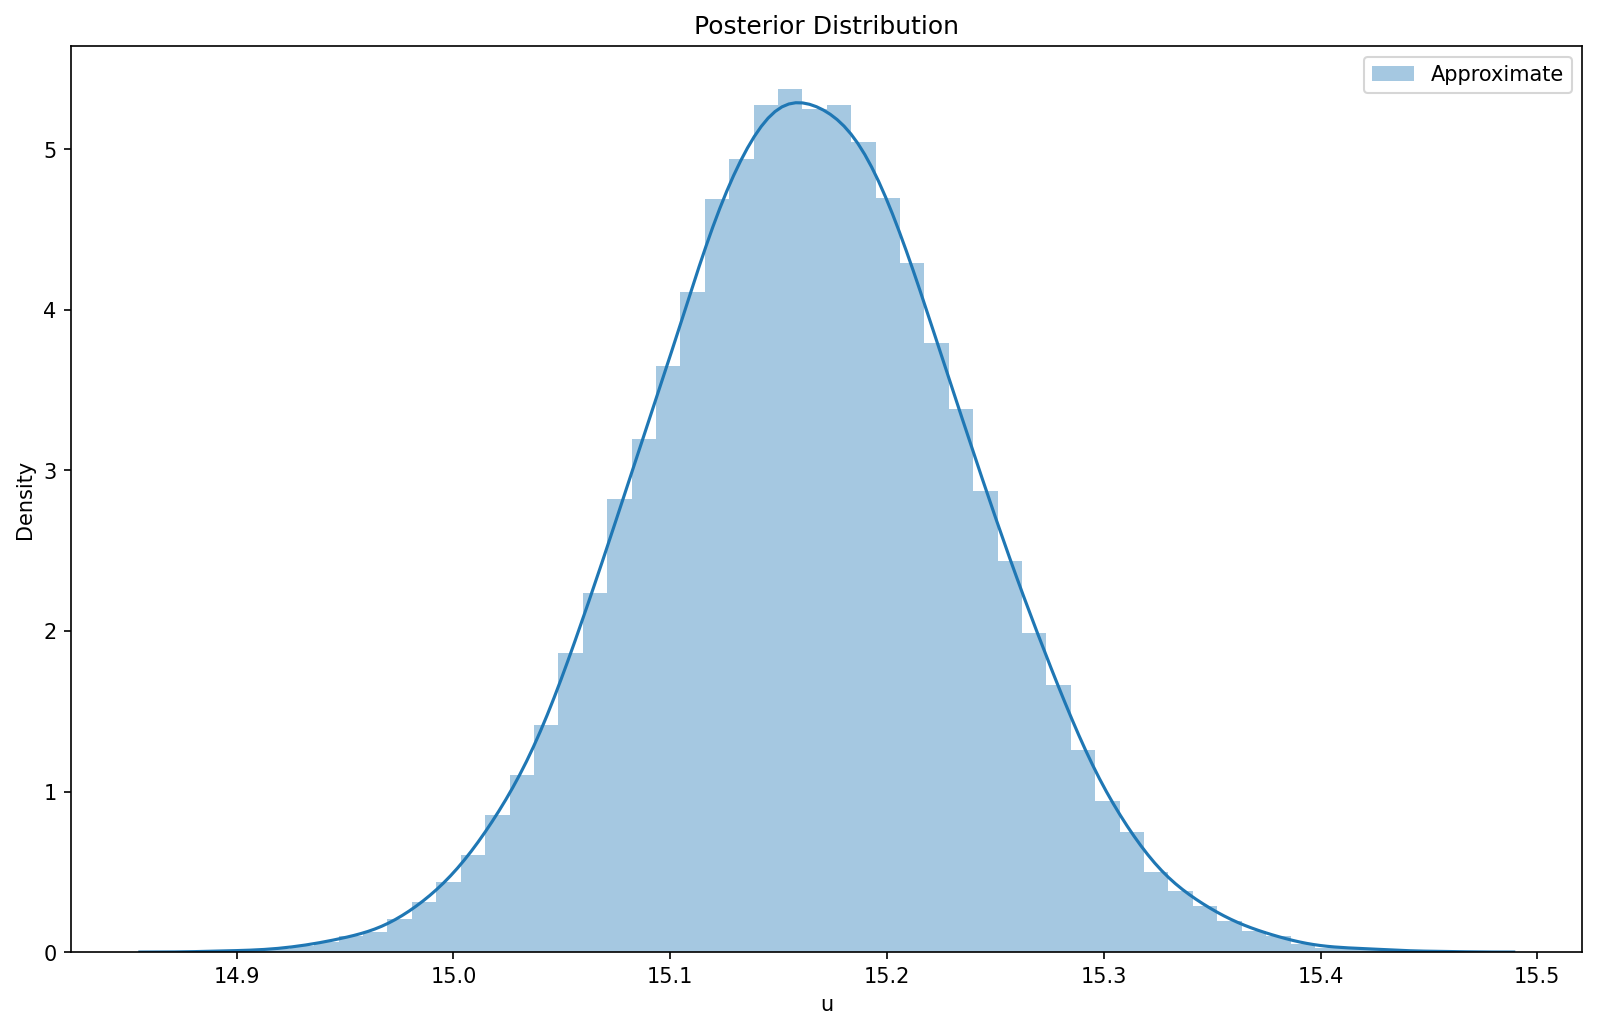

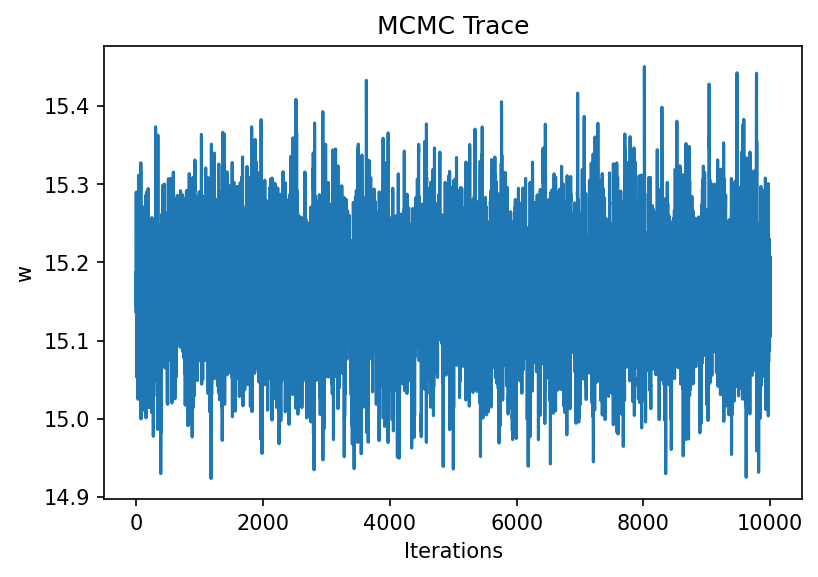

In [16]:
plt.figure(figsize=(13,8), dpi=150)
sns.distplot(res, label="Approximate", norm_hist=True) #hmc_samples["w"]
plt.xlabel("u")
plt.title("Posterior Distribution")
plt.legend()
plt.savefig("plot_task4c.png")
plt.figure(dpi=150)
plt.plot(np.arange(0, res.shape[0]), save_posteriors[6]["w"], label="MCMC")
plt.ylabel("w")
plt.xlabel("Iterations")
plt.title("MCMC Trace")